In [2]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)


with open("./DATACON_data/cpzp_persons.pkl", "rb") as f:
    cpzp_persons: list[Person] = pickle.load(f)

with open("./DATACON_data/ozp_persons.pkl", "rb") as f:
    ozp_persons: list[Person] = pickle.load(f)

In [5]:
from common.constants.objects import Vaccine


persons = sorted(ozp_persons, key=lambda p: p.id)
dead_persons = [p for p in persons if p.died_at and p.vaccines]

dead_indexes_map = {}

first_pr_from_first_dose_map = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
    8: {},
}

first_pr_map_no_vax_segregation = {}

first_pr_map_vax_segregation = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
    8: {},
}


for p in dead_persons:
    # last_vax_date = p.vaccines[-1].date if p.vaccines else None
    last_vax_date = p.vaccines[0].date if p.vaccines else None
    if last_vax_date:
        day_of_death = p.died_at
        # if day_of_death.day == 1:
        #     next_month = (day_of_death.replace(day=28) + timedelta(days=4)).replace(
        #         day=1
        #     )
        #     day_of_death = next_month - timedelta(days=1)

        days_after_last_vax = (day_of_death - last_vax_date).days
        if days_after_last_vax < 0:
            continue
        if days_after_last_vax not in dead_indexes_map:
            dead_indexes_map[days_after_last_vax] = 1
        else:
            dead_indexes_map[days_after_last_vax] += 1


def find_closest_date(target_date: datetime, dates: list[Vaccine]):
    if not dates:
        return None
    return max(dates, key=lambda d: target_date - d.date)


n_of_imunosuppresives = 0
n_of_corts = 0
for p in persons:
    first_prescription_date = p.prescriptions[0].date if p.prescriptions else None
    first_vax_date = p.vaccines[0].date if p.vaccines else None

    if first_prescription_date and first_vax_date:
        if not p.prescriptions[0].equiv_sloucenina:
            n_of_imunosuppresives += 1
            continue
        else:
            n_of_corts += 1
        closest_vax_date = (
            find_closest_date(first_prescription_date, p.vaccines).date
            if p.vaccines
            else None
        )

        days_after_first_prescription = (first_prescription_date - first_vax_date).days
        # print(first_prescription_date, first_vax_date, days_after_first_prescription)
        if days_after_first_prescription not in first_pr_map_no_vax_segregation:
            first_pr_map_no_vax_segregation[days_after_first_prescription] = 1
        else:
            first_pr_map_no_vax_segregation[days_after_first_prescription] += 1

        if (
            days_after_first_prescription
            not in first_pr_from_first_dose_map[
                len(p.vaccines)
            ]  # kolik má člověk celkově vakcín
        ):
            first_pr_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] = 1
        else:
            first_pr_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] += 1

        if closest_vax_date:
            days_after_closest_vax = (first_prescription_date - closest_vax_date).days
            if (
                days_after_closest_vax
                not in first_pr_map_vax_segregation[len(p.vaccines)]
            ):
                first_pr_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] = 1
            else:
                first_pr_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] += 1

print(n_of_imunosuppresives)
print(n_of_corts)

4343
198257


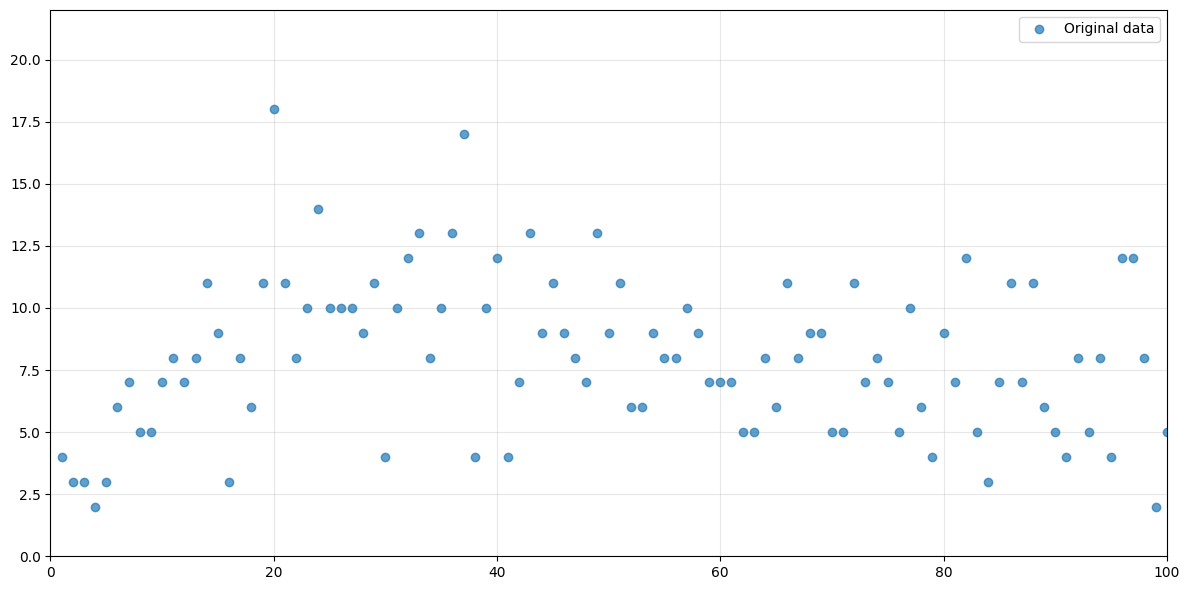

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

x_data = list(dead_indexes_map.keys())
y_data = list(dead_indexes_map.values())

sorted_days_after_last_vax, sorted_first_prescription_counts = zip(
    *sorted(zip(x_data, y_data))
)

window_size = 7  # Adjust as needed

plt.plot(
    sorted_days_after_last_vax,
    sorted_first_prescription_counts,
    label="Original data",
    alpha=0.7,
    marker="o",
    linestyle="None",
)
plt.xlim(0, 100)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

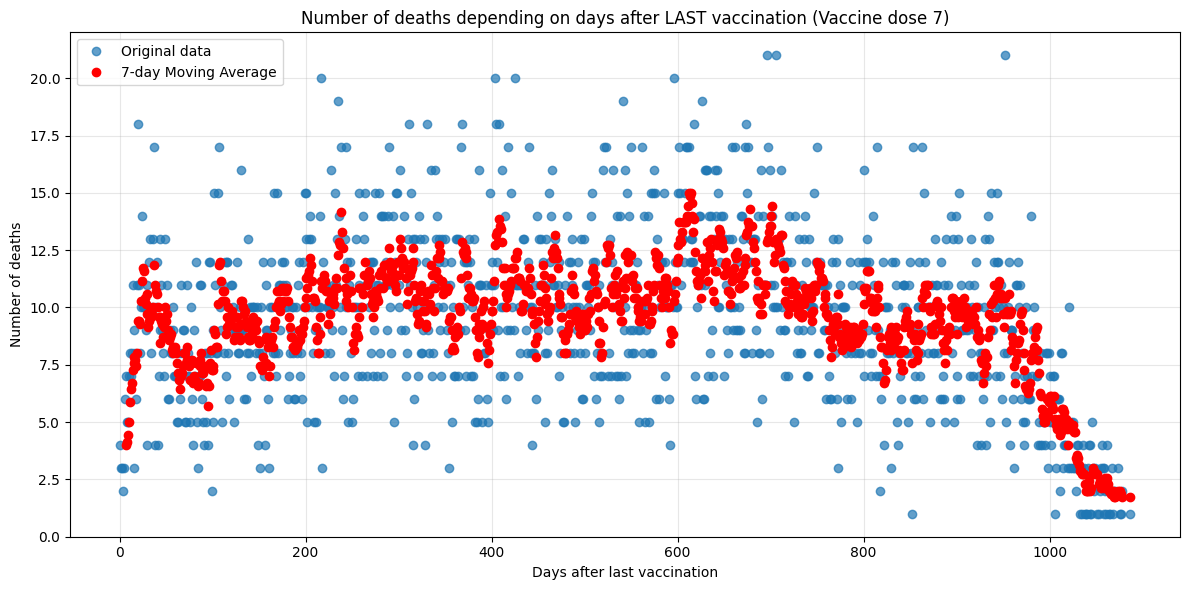

In [6]:
# === HVE per each dose ===
draw_chart(
    dead_indexes_map,
    "Days after last vaccination",
    "Number of deaths",
    f"Number of deaths depending on days after LAST vaccination (Vaccine dose {vaccine_amount})",
)

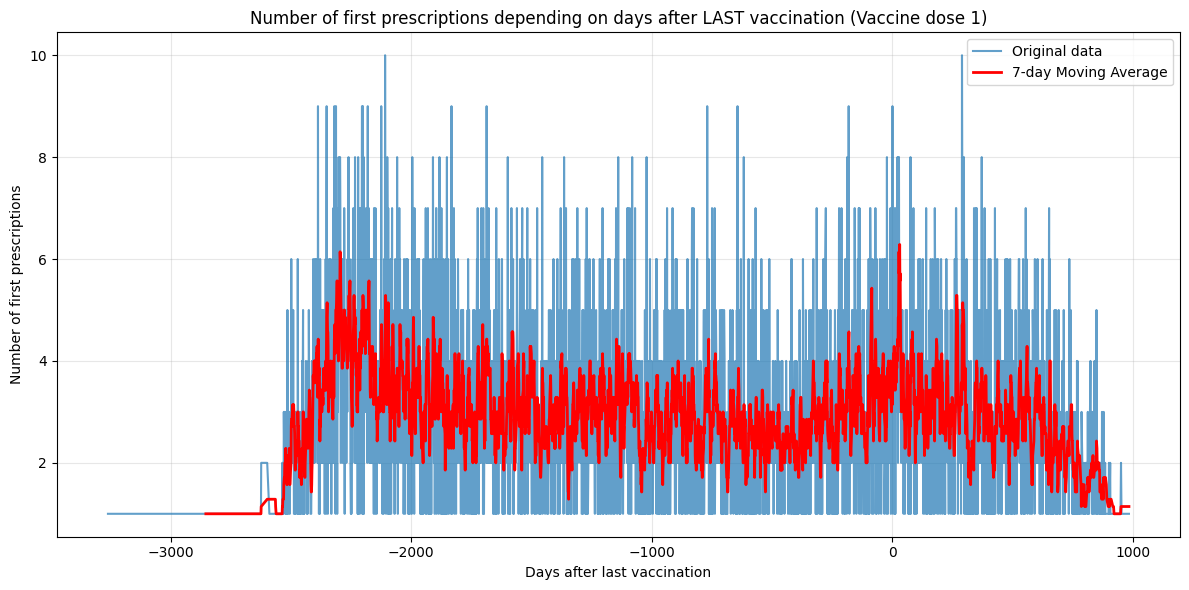

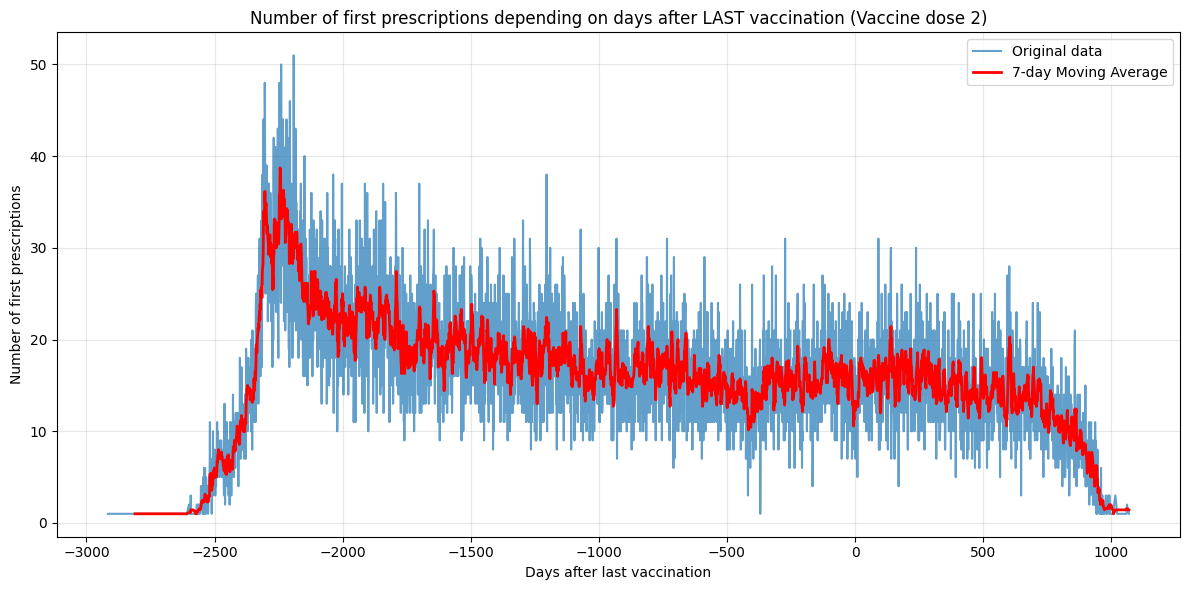

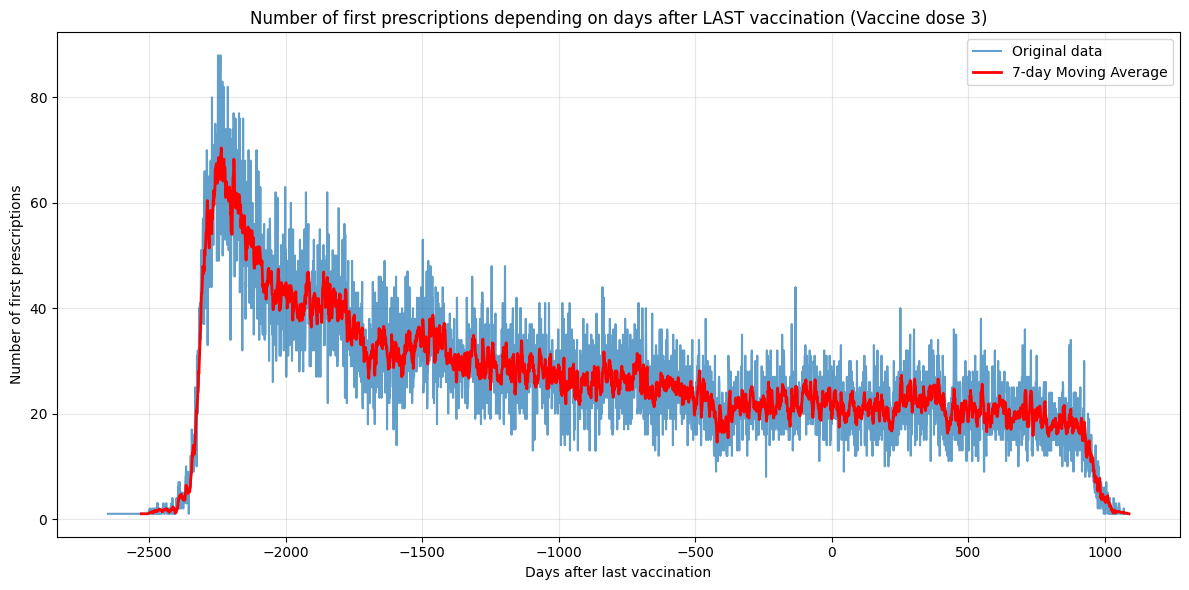

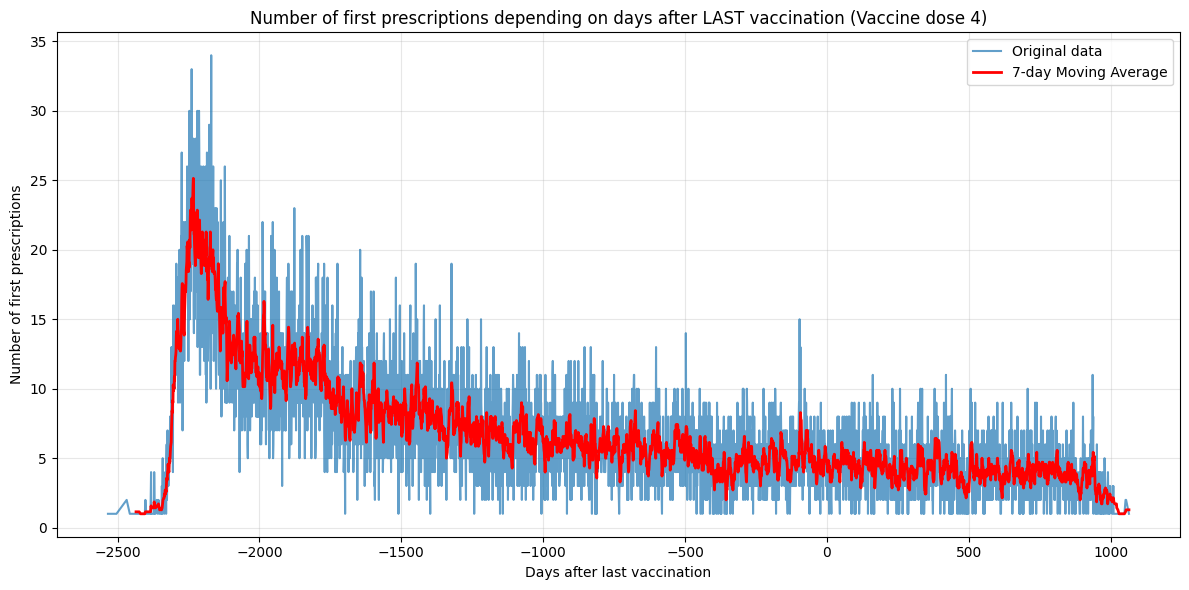

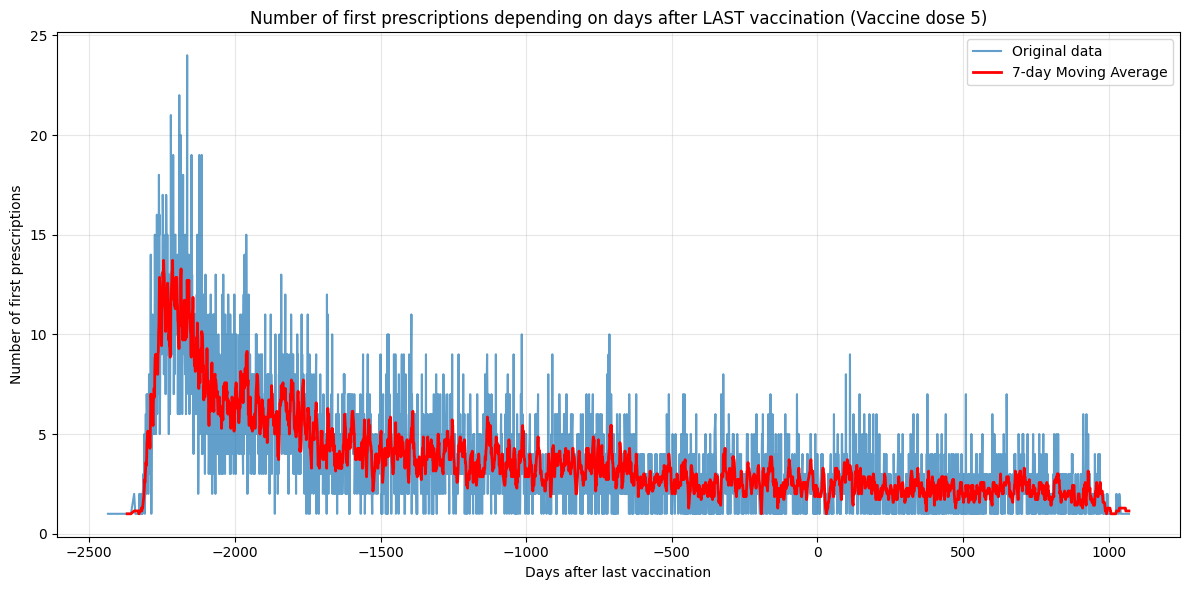

In [22]:
# === Number of first prescriptions depending on days after LAST vaccination (ONE BY ONE for each dose) ===

for vaccine_amount, indexes_map in first_pr_map_vax_segregation.items():
    draw_chart(
        indexes_map,
        "Days after last vaccination",
        "Number of first prescriptions",
        f"Number of first prescriptions depending on days after LAST vaccination (Vaccine dose {vaccine_amount})",
    )

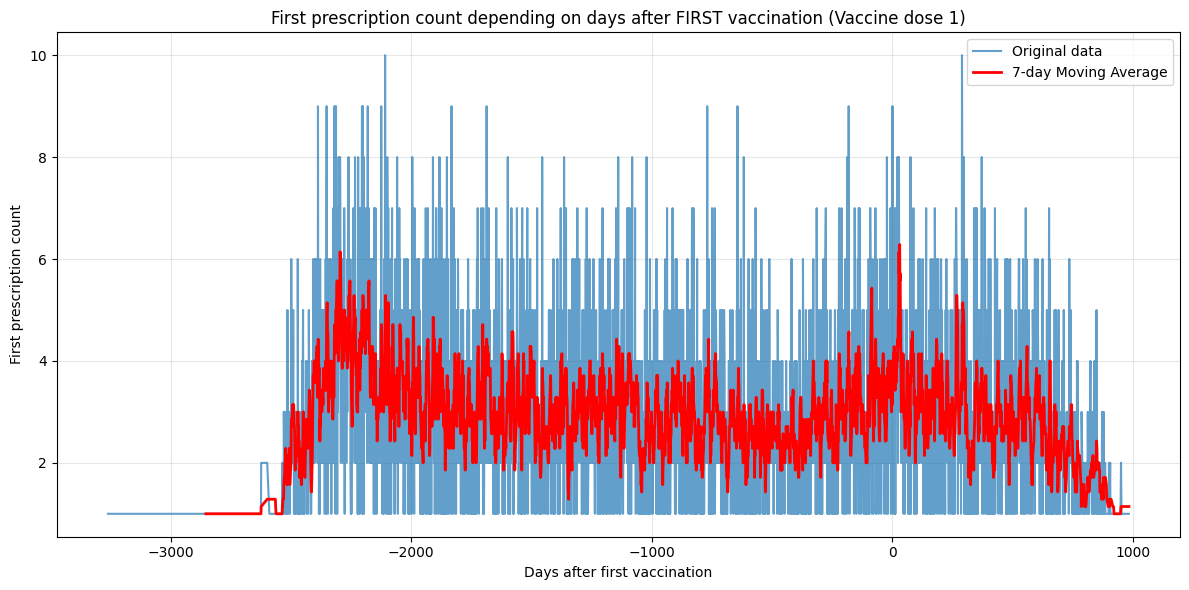

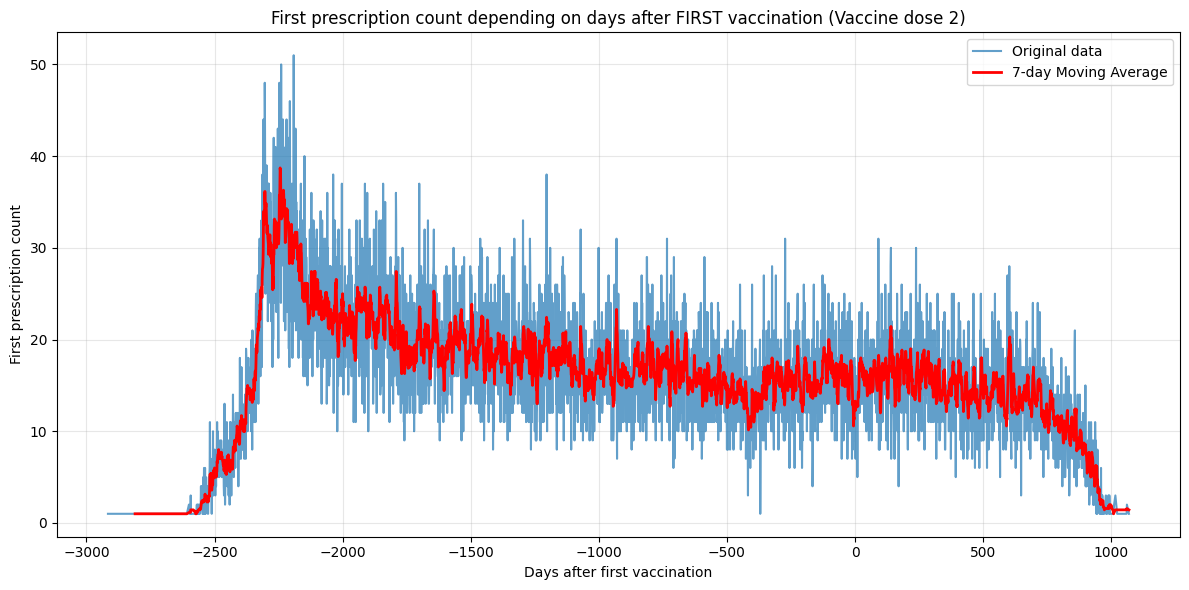

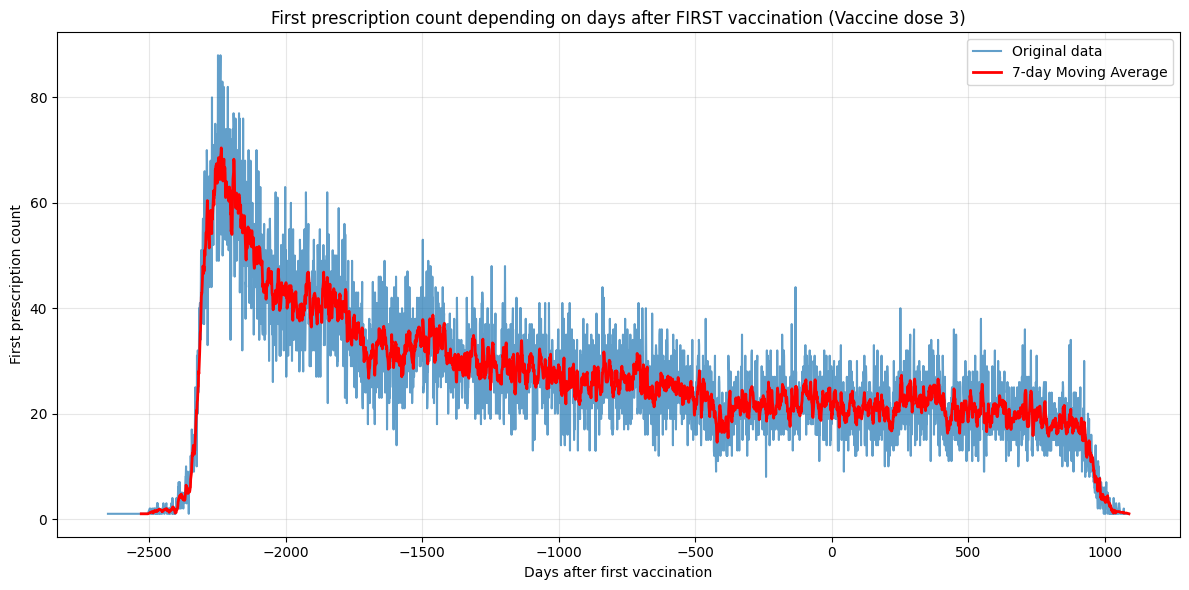

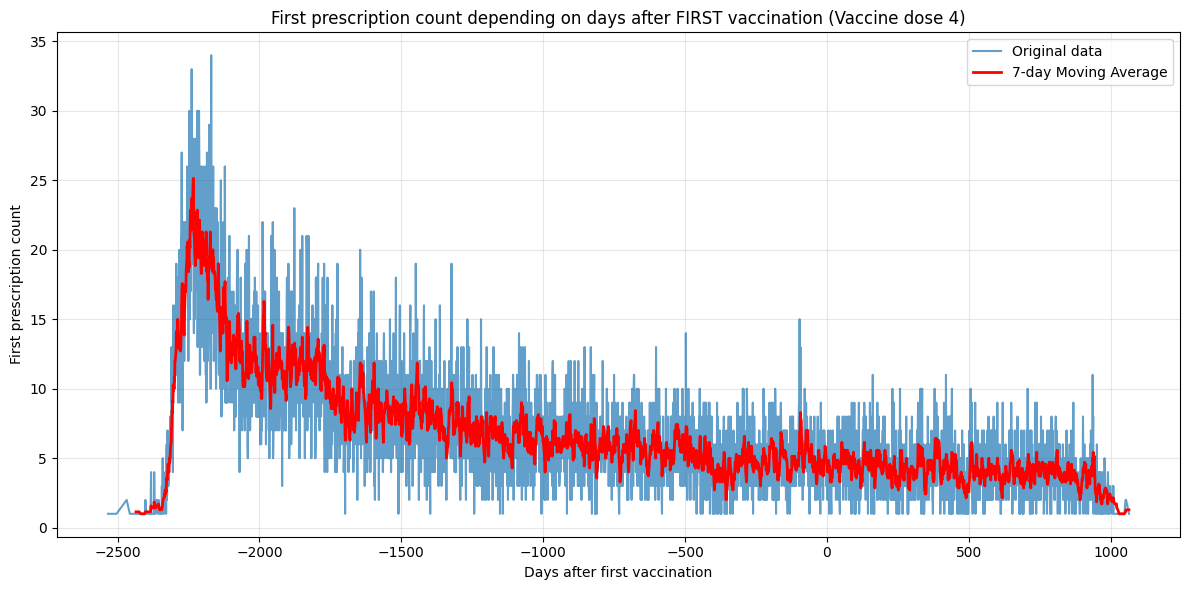

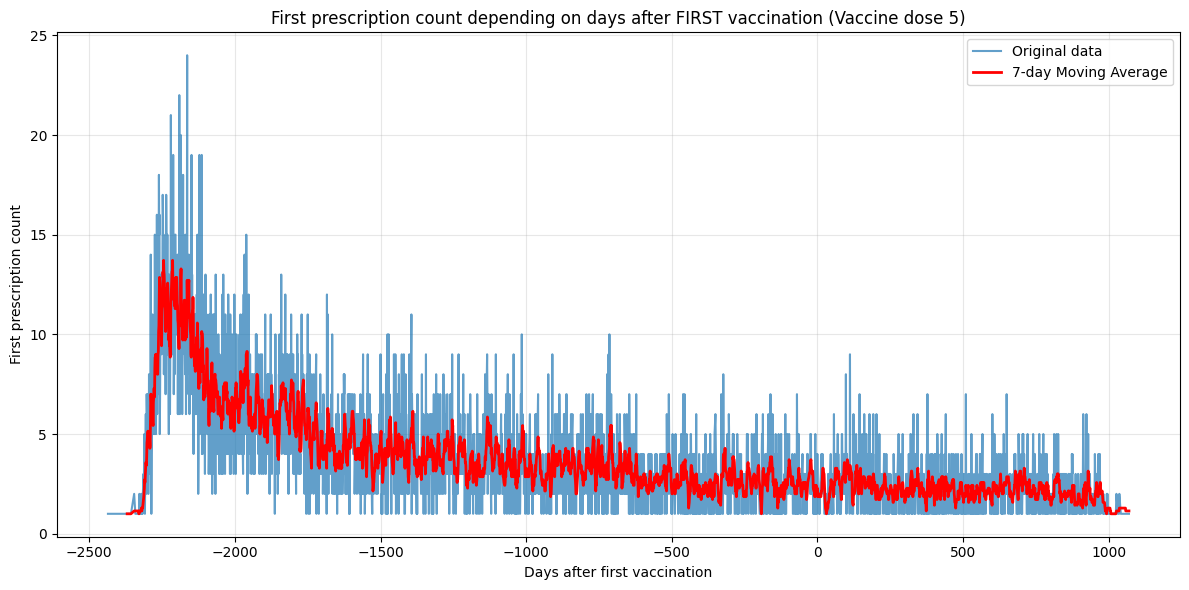

In [23]:
# === Number of first prescriptions depending on days after FIRST vaccination (ONE BY ONE for each dose) ===

for vaccine_amount, indexes_map in first_pr_from_first_dose_map.items():
    draw_chart(
        indexes_map,
        "Days after first vaccination",
        "First prescription count",
        f"First prescription count depending on days after FIRST vaccination (Vaccine dose {vaccine_amount})",
    )

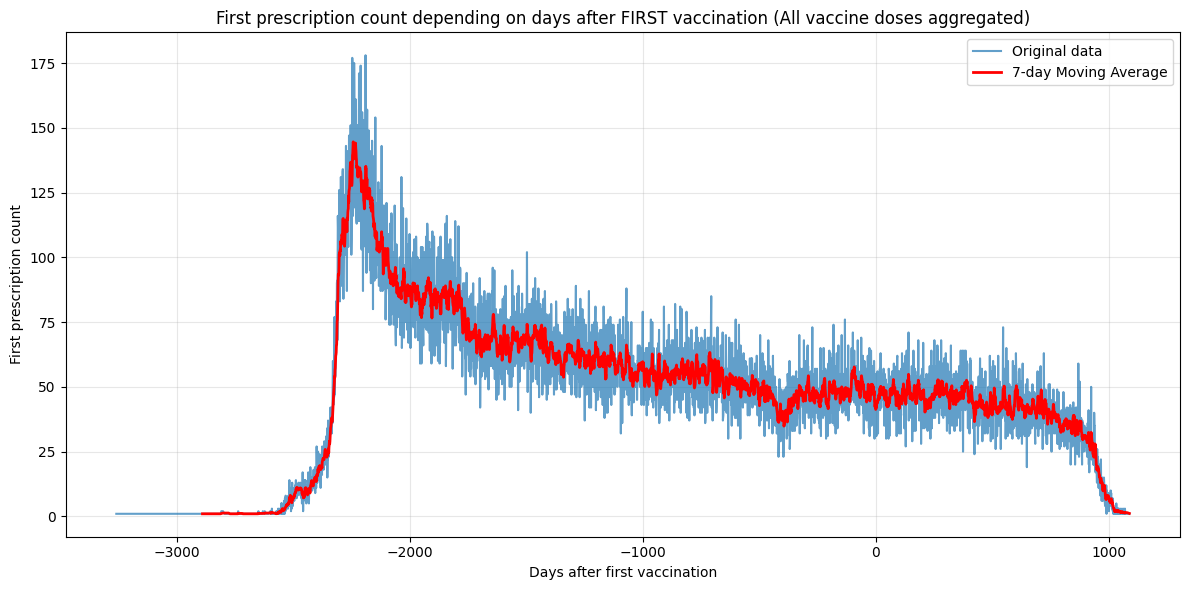

In [24]:
# === Number of first prescriptions depending on days after FIRST vaccination (ALL DOSES AGGREGATED) ===

draw_chart(
    first_pr_map_no_vax_segregation,
    "Days after first vaccination",
    "First prescription count",
    "First prescription count depending on days after FIRST vaccination (All vaccine doses aggregated)",
)

In [14]:
quick_map = {}
for p in ozp_persons:
    if not p.prescriptions:
        continue

    for pr in p.prescriptions:
        prvopredpis_date = pr.date
        if prvopredpis_date not in quick_map:
            quick_map[prvopredpis_date] = 1
        else:
            quick_map[prvopredpis_date] += 1

print(quick_map)

{datetime.date(2019, 8, 26): 642, datetime.date(2019, 9, 27): 517, datetime.date(2019, 9, 30): 734, datetime.date(2019, 10, 21): 743, datetime.date(2019, 10, 22): 764, datetime.date(2019, 10, 23): 754, datetime.date(2019, 10, 24): 723, datetime.date(2019, 10, 25): 590, datetime.date(2020, 3, 5): 632, datetime.date(2020, 3, 12): 651, datetime.date(2020, 4, 7): 499, datetime.date(2020, 4, 17): 443, datetime.date(2020, 6, 23): 747, datetime.date(2021, 3, 30): 686, datetime.date(2015, 12, 4): 539, datetime.date(2016, 2, 4): 628, datetime.date(2017, 6, 29): 677, datetime.date(2018, 12, 13): 731, datetime.date(2023, 8, 24): 642, datetime.date(2020, 1, 9): 763, datetime.date(2020, 2, 6): 748, datetime.date(2020, 2, 20): 684, datetime.date(2020, 3, 13): 546, datetime.date(2020, 3, 20): 403, datetime.date(2020, 4, 3): 382, datetime.date(2020, 4, 15): 617, datetime.date(2020, 4, 23): 587, datetime.date(2020, 5, 7): 694, datetime.date(2020, 5, 14): 735, datetime.date(2020, 5, 21): 736, datetime.d

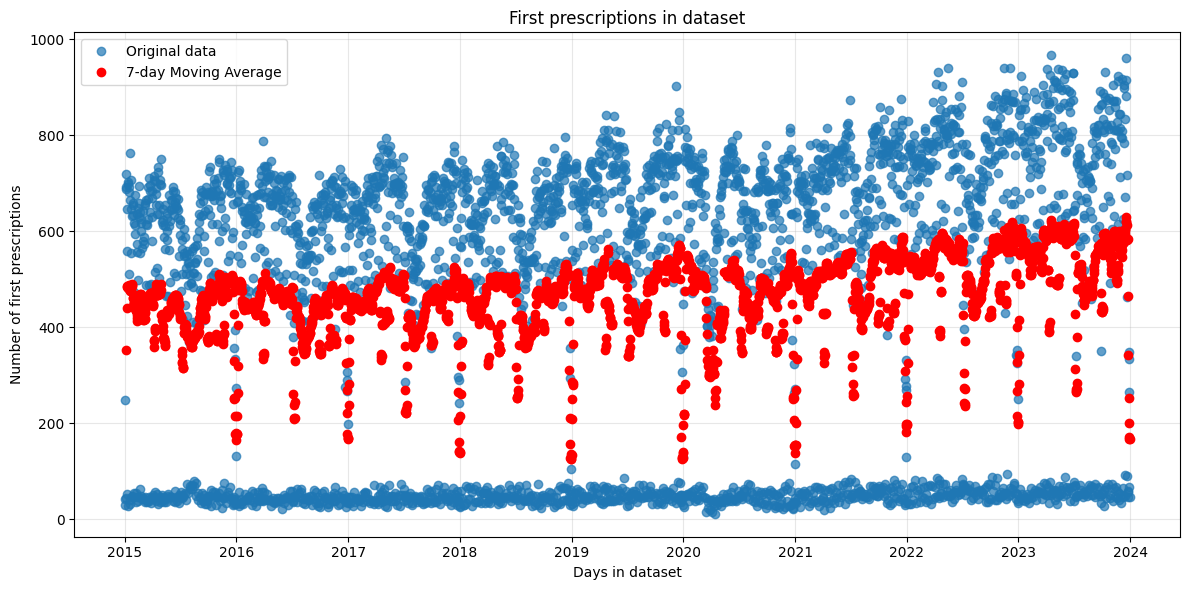

In [15]:
draw_chart(
    mapp=quick_map,
    x_label="Days in dataset",
    y_label="Number of first prescriptions",
    title="First prescriptions in dataset",
)

{1231: 24, 1327: 23, 21: 158, 2747: 4, 522: 57, 33: 150, 1590: 20, 34: 132, 951: 37, 977: 33, 2139: 17, 49: 105, 1799: 28, 217: 47, 1848: 46, 2883: 40, 2405: 22, 1177: 27, 644: 44, 1113: 23, 1026: 44, 182: 66, 1336: 22, 22: 133, 2736: 31, 442: 52, 1065: 16, 3078: 31, 335: 77, 2531: 39, 2442: 32, 1094: 9, 1891: 20, 1883: 34, 273: 56, 3145: 7, 2535: 34, 141: 68, 570: 10, 869: 20, 299: 89, 3121: 20, 67: 109, 1652: 29, 193: 62, 1516: 46, 1903: 22, 2746: 6, 2286: 3, 2794: 13, 215: 56, 3279: 8, 3272: 6, 154: 91, 186: 9, 3073: 29, 78: 82, 207: 50, 754: 52, 2618: 23, 3129: 15, 3025: 25, 204: 57, 1713: 20, 1989: 15, 2475: 38, 277: 79, 28: 165, 690: 46, 342: 71, 2464: 37, 454: 51, 389: 51, 1224: 36, 722: 31, 906: 8, 1699: 19, 1539: 21, 593: 37, 102: 125, 1250: 30, 663: 39, 1495: 26, 484: 35, 20: 180, 2863: 32, 88: 100, 711: 37, 2366: 23, 2317: 28, 2872: 9, 1468: 19, 2280: 26, 133: 90, 3084: 33, 1267: 29, 3123: 19, 106: 71, 6: 192, 2566: 21, 2275: 23, 2625: 26, 3093: 23, 38: 14, 764: 29, 89: 80, 

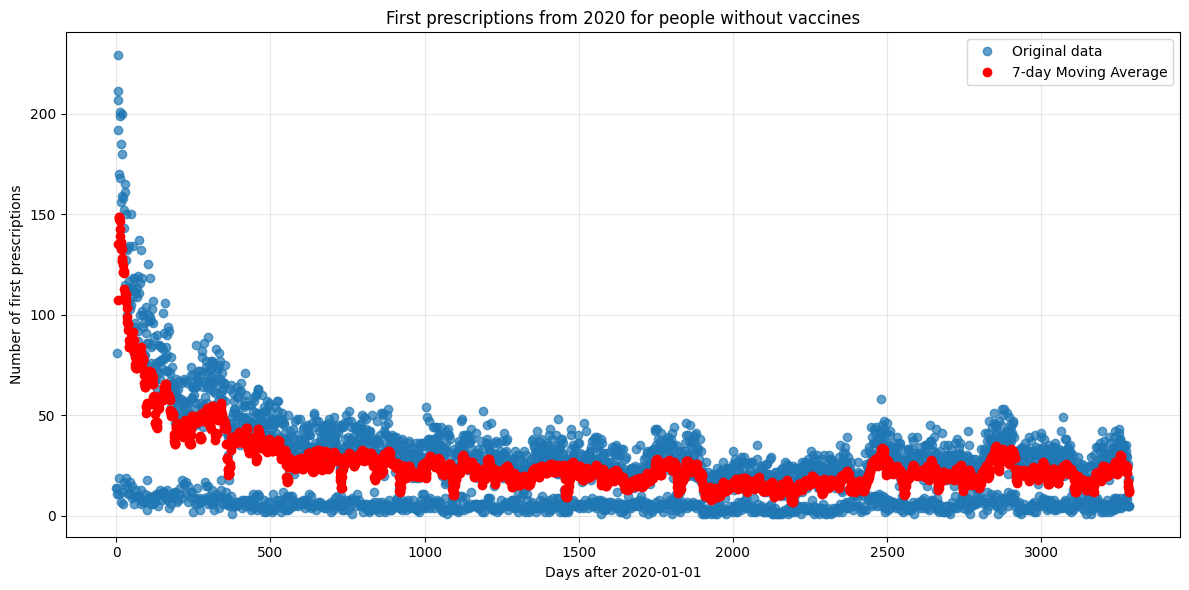

In [16]:
from_date = datetime(2015, 1, 1).date()
first_pr_from_2020 = {}

for p in persons:
    first_prescription_date = p.prescriptions[0].date if p.prescriptions else None
    if first_prescription_date and not p.vaccines:
        if first_prescription_date < from_date:
            continue

        days_after_first_prescription = (first_prescription_date - from_date).days
        if days_after_first_prescription not in first_pr_from_2020:
            first_pr_from_2020[days_after_first_prescription] = 1
        else:
            first_pr_from_2020[days_after_first_prescription] += 1

print(first_pr_from_2020)

draw_chart(
    mapp=first_pr_from_2020,
    x_label="Days after 2020-01-01",
    y_label="Number of first prescriptions",
    title="First prescriptions from 2020 for people without vaccines",
)